# figure 3, finding feedforward timing 

In [1]:
import numpy as np
from scipy.integrate import odeint  
from operator import sub 
import controlpy   
import pickle

from matplotlib import  rc    
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import rcParams 

import sys 
import  os 

# append function path to system
base_path = os.path.abspath(os.path.join( os.getcwd()   , os.pardir ) )
function_path = os.path.join(  base_path, 'functions') 
sys.path.append(function_path ) 
 
figs_path = os.path.join(  base_path, 'figs') 
data_path = os.path.join(  base_path, 'data')
    
# import custom functions 
from figure_settings import *    
import figure_functions as ff
import phasediagram as phd
import singlependulum as sp  
import dynamicpendulums.figureparam as fp

In [2]:
# General Plotting Parameters 
fig_dim = (6.2, 2.2 )  
fig_name = 'fig3_feedforward' 
LQR_limit = 0.3

rectangle_order = -4 

In [3]:
filename_IC = os.path.join( data_path,  'feedforward_manyIC.pkl' )
with open( filename_IC, 'rb') as f:
    result_list = pickle.load( f) 

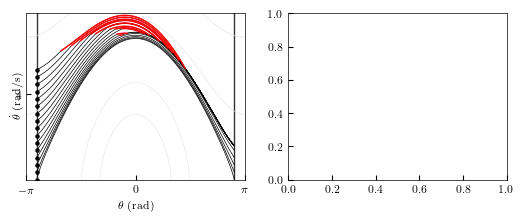

In [4]:
fig,(ax0,ax1) = plt.subplots(1,2,figsize=fig_dim, dpi = 100) 
 
def plot_many_IC(ax_p): 
# Ax0 -----------------------------------------------------------------------
    ff.plot_add_contours(ax_p)  
    # plot_state_space(ax0)

    for j, [cost,time,y_data,u_data] in enumerate(result_list) : 
        if np.mod(j,2) ==0:
            u_bool = np.abs(u_data) > 0 
            ax_p.plot(y_data[:,0],y_data[:,1],'k',linewidth = 0.5)
            ax_p.plot(y_data[u_bool,0],y_data[u_bool,1],color=ff_col,linewidth = 1)
            ax_p.scatter( y_data[0,0], y_data[0,1],5,'k') 


    # phd.homoclinic_plot(ax0) 
    ax_p.set_xlim([-np.pi,np.pi]) 
    ax_p.set_ylim([.5,7.3]) 

    rectangle_order = -4 
    L = 16 
    
    rectangle_col = np.ones((3))
    rectangle1 = plt.Rectangle( ( -np.pi+0.3,-L/2), 2*np.pi-0.6,L, 
                                zorder=rectangle_order ,facecolor=rectangle_col, edgecolor=obscure_edge ,alpha = obscure_alpha) 
    ax_p.add_patch(rectangle1)

    ax_p.set_xlabel(r'$\theta$ (rad)' )
    ax_p.set_ylabel(r'$\dot{\theta}$ (rad/s)',   va = 'top') 
    
    
    ax_p.yaxis.set_major_locator( plt.MultipleLocator(4) ) 
    ax_p.xaxis.set_major_locator(plt.MultipleLocator(np.pi )) 
    ax_p.xaxis.set_major_formatter(plt.FuncFormatter(phd.multiple_formatter()))   
    
    
    
    return(ax_p)

plot_many_IC(ax0) 


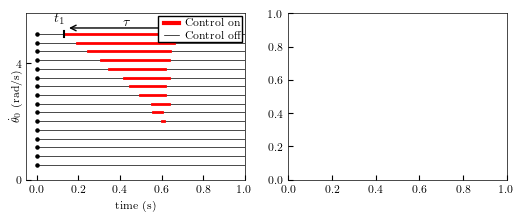

In [5]:
fig,(ax0,ax1) = plt.subplots(1,2,figsize=fig_dim, dpi = 100) 

def plot_IC_u(ax_p):
    # Ax1 -----------------------------------------------------------------------
    for j, [cost,time,y_data,u_data] in enumerate(result_list) : 
        if np.mod(j,2) ==0: 
            y0 = y_data[0,1] 
            u_bool = np.abs(u_data) > 0 
            ax_p.plot( time, time*0 + y0, 'k',linewidth = 0.5) 
            ax_p.plot( time[u_bool], time[u_bool]*0 + y0 ,color=ff_col,linewidth = 2) 
            ax_p.scatter( 0, y_data[0,1],5,'k') 

    ax_p.set_xlim([-0.05,1])
    ax_p.set_ylim([0,5.7])

    ax_p.set_xlabel('time (s)') 
    ax_p.set_ylabel(r'$\dot{\theta}_0$ (rad/s)' ,   va = 'top') 

#     ax_p.text(0.1,5.2,r'$t_{start}$' )
#     ax_p.text(0.4,5.2,r'$\tau$' )
    
    ax_p.plot([-5,-5,],[-5,-4],color=ff_col,label='Control on',linewidth=3)
    ax_p.plot([-5,-5,],[-5,-4],'k',label='Control off',linewidth=0.5,)
    ax_p.legend( fontsize = 8  )
    

    u_bool = np.where(np.abs(u_data) > 0)[0]
    t1 = time[ u_bool[0] ]
    t2 = time[ u_bool[-1]+15 ]
    t1,t2

    # ax0.arrow(  t1,5.2,t2-t1 ,  0 )
    # time
    ax_p.annotate("", xy=( t1+0.01, 5.2), xytext=(t2-0.01, 5.2),    arrowprops=dict(arrowstyle='<->')  ) 
    ax_p.annotate(r'$\tau$', xy=( t1+(t2-t1)/2, 5.3)  )

    ax_p.annotate(r'$t_{1}$', xy=(t1-0.05, 5.35) )  
    ax_p.plot([t1,t1],[4.9,5.1],'k')
    ax_p.plot([t2,t2],[4.9,5.1],'k')

    
    ax_p.yaxis.set_major_locator( plt.MultipleLocator(4) ) 
    

    return( ax_p ) 

plot_IC_u( ax0) 


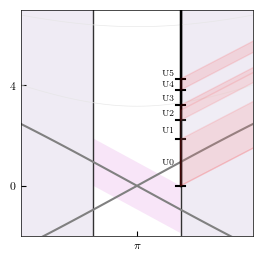

In [6]:
A = np.matrix([[0.,1.],[-10.,0. ]])
B = np.matrix([[0.],[1.]])
Q = np.matrix([[11., 0.],[0.,1.]])*1e4
R = np.matrix([1.])  

K,__,__ = controlpy.synthesis.controller_lqr(A,B,Q,R)  
 
def pendulum_dynamics( y_n, t , K  ):
    L = 1. 
    mp = 1. 
    g = -10.
    b = 0.01
    y_f = np.array([np.pi,0])
       
    u = np.clip( np.dot( K,(y_f -y_n) ) ,-3,3)  
    
    fy = np.zeros(y_n.shape)    
    fy[0]=    y_n[1]  
    fy[1] =    mp*L*g/(mp*L**2)*np.sin( y_n[0] ) -b/(mp*L**2)*y_n[1] + u/(mp*L**2)
    return fy
 
def plot_LQR_region( ax_p):
    nx = 2
    ny = 10 

#     TH, DTH = np.meshgrid(th,dth)  
    y_f = np.array([np.pi,0])

    dt = 0.01; 
    tLast = 4
    tInt = np.arange(0,tLast+dt, dt)    

    result_list = []
    
    ny = 10
    dth_range = np.linspace(1,5.,ny) 
    th_range = dth_range*0 + 0.15  +np.pi
    dth_mat = np.vstack( (th_range,dth_range)  ).transpose()
    dth_mat[0]

    for j in range(ny): 
        
        th0 = dth_mat[j,0]
        dth0 = dth_mat[j,1]
#     for th0 in th:
#         for dth0 in dth:  
        y0 = np.array( [th0,dth0] )  
        new_point = y0
        point1 = np.array([np.pi-0.3, 1.88])
        point2 = np.array([np.pi+0.3, 0]) 
        point3 = np.array([np.pi-0.3, 0])
        point4 = np.array([np.pi+0.3, -1.88])

        slope = (point2[1]-point1[1])/(point2[0]-point1[0])
        new_point = y0 
        maxy_in = point1[1]+(new_point[0]-point1[0])*slope
        miny_in = point3[1]+(new_point[0]-point3[0])*slope

        LQR_inx = ((y0[0]> visible_x[0]) & (y0[0] < visible_x[1])  )   
        LQR_iny  =  (new_point[1] < maxy_in) & (new_point[1] > miny_in) 
        LQR_bool = LQR_inx & LQR_iny 
        if LQR_bool:
            y = odeint( pendulum_dynamics,y0, tInt , args=(K,)   ) 
        else:
            y = odeint( pendulum_dynamics,y0, tInt , args=(K*0,)   )  
        err = y_f - y
        u = [ np.clip(np.dot( K,e),-3,3) for e in err ]  

        converge_bool = np.linalg.norm( err[-1] ) <1e-3 
        result_list.append( [y0,converge_bool,y,u] ) 
            
    bool_conv = [ list[1] for list in result_list] 
    IC = [ list[0] for list in result_list]       
 
#     filename_grouped = 'feedforward_grouping_minimal_set.pkl'
    filename_grouped = os.path.join( data_path,  'feedforward_grouping_minimal_set.pkl' )
    with open(filename_grouped, 'rb') as f:
        mynewlist = pickle.load(f)
    u_param, dth_start, dth_end = mynewlist 
 
    u_list = []  
    
    phd.homoclinic_plot(ax_p ,0,2*np.pi, col = homoclinic_col )  
    ax_p.set_xlim( np.array([-1,1])*.8+np.pi)
    ax_p.set_ylim( np.array([-1,1])*5 )  
    x_lim = np.pi -  LQR_limit 
    L = 16
    rectangle1 = plt.Rectangle( (0,-L/2), visible_x[0],L, 
                                zorder=-5, facecolor = obscure_col ,alpha = obscure_alpha, edgecolor=obscure_edge) 
    ax_p.add_patch(rectangle1)
    rectangle2 = plt.Rectangle( (visible_x[1],-L/2), 2*np.pi,L, 
                                zorder=-5, facecolor = obscure_col ,alpha = obscure_alpha, edgecolor=obscure_edge) 
    ax_p.add_patch(rectangle2) 
    dx = LQR_limit 

    x_points = np.array([-dx, dx, dx, -dx])+np.pi
    y_points = np.array([1.,0,-1.,0])*1.88
    ax_p.fill( x_points, y_points,facecolor=lqr_fill, zorder = -6,alpha=0.1) 

    for j,(st, end) in enumerate(zip(dth_start,dth_end)) : 

        x_loc = np.array([-1,1])*0.03+np.pi+fp.LQR_limit
        y_loc = np.array([1,1])*st
        ax_p.plot(x_loc,y_loc,'k')
        ax_p.plot( np.array([1,1])*np.pi+  LQR_limit , [0,8], color= 'k') 
        y_text = np.average([st,end]) -0.1
#         ax_p.text( np.pi+fp.LQR_limit + 0.2  , y_text+0.1+ 0.6, 'U'+str(j), color=text_col, fontsize = u_size )

        ax_p.text( np.pi+ LQR_limit - 0.13  , y_text , 'U'+str(j), fontsize = 6)

#         x_loc = np.array([-1,1])*0.03+ np.pi-fp.LQR_limit
#         y_loc = -np.array([1,1])*st
#         ax_p.plot(x_loc,y_loc,'k')
#         ax_p.plot( np.array([1,1])*np.pi-fp.LQR_limit , [0,-8], color='k' )  
#         y_text = -np.average([st,end]) -0.15
#         ax_p.text( np.pi-0.25 ,  y_text, 'U'+str(j), color= text_col , fontsize = u_size  )

        if np.mod(j,2) == 0:
            delta_th = end-st
            vx = 1
            grad = 3
            x_points = np.array([0,1,1,0])*vx + np.pi + 0.3  
            y_points = np.array([  delta_th, delta_th+grad*vx,grad*vx,0])  + st

            ax_p.fill( x_points, y_points,facecolor='r',edgecolor='r', zorder = 3,alpha=0.1) 

        
    ax_p.yaxis.set_major_locator( plt.MultipleLocator(4) ) 
    ax_p.xaxis.set_major_locator(plt.MultipleLocator(np.pi )) 
    ax_p.xaxis.set_major_formatter(plt.FuncFormatter(phd.multiple_formatter()))   
     
    return( ax_p ) 

# obscure_col = np.ones((3))*0.9 

fig,ax = plt.subplots(1,1, figsize= (3,3) ,dpi = 100)


ff.plot_add_contours(ax)  
    
plot_LQR_region(ax) 


ax.set_ylim([-2,7])


dth_end = 3
dth_start =0

delta_th = (dth_end-dth_start)
vx = 1
grad = 3
x_points = np.array([0,1,1,0])*vx + np.pi + 0.3
y_points = np.array([  delta_th, delta_th+grad*vx,grad*vx,0])  

ax.fill( x_points, y_points,facecolor='w',edgecolor='r', zorder = 3,alpha=0.1) 
    

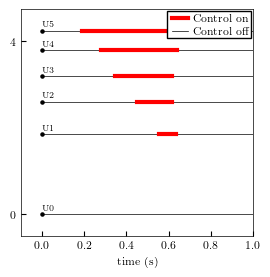

In [7]:
fig,ax = plt.subplots(1,1, figsize= (3,3) ,dpi = 100)

def plot_u_trajectories( ax_p ):
    
#     with open('u_grouping.pkl', 'rb') as f: 
    filename_minimal = os.path.join( data_path,  'feedforward_grouping_minimal_set.pkl' )
    with open(filename_minimal, 'rb') as f:
        mynewlist = pickle.load(f)
    u_param, dth_start, dth_end = mynewlist 
     
    dth_start
    for j, arr in enumerate( u_param ): 
        t1= arr[0]
        tau = arr[1] 

        y_plot = dth_start[j]
        t_end =1
        dt = 0.001
        tInt = np.arange(0,t_end,dt) 
        u = np.zeros( (len(tInt) ))
        bool_on = (tInt>t1) & (tInt < (t1+tau) )
        u[bool_on]= -3

        ax_p.plot( tInt, tInt*0+ y_plot,'k',linewidth=0.5)
        
        ax_p.scatter( 0,y_plot,5,'k') 

        ax_p.plot( tInt[bool_on], u[bool_on]*0+y_plot, ff_col ,linewidth=3 ) 
    
        ax_p.text(0,y_plot+0.1, 'U'+str(j), fontsize = 6 )
        
        
    ax_p.set_ylim([-0.5,y_plot+0.5]) 
    ax_p.set_xlim([-0.1,1]) 
    ax_p.set_xlabel('time (s) ') 
#     ax_p.yaxis.set_ticks([]) 

    ax_p.plot([-5,-5,],[-5,-4],color=ff_col,label='Control on',linewidth=3)
    ax_p.plot([-5,-5,],[-5,-4],'k',label='Control off',linewidth=0.5,)
    ax_p.legend( fontsize = 8 )
    
    ax_p.yaxis.set_major_locator( plt.MultipleLocator(4) ) 
    
    return( ax_p)  


plot_u_trajectories( ax ) 


In [8]:
fig = plt.figure( figsize= fig_dim,dpi = 100)
  
   
ax0= plt.axes([ 0 , 0 , .35     ,  1] )  
ax1= plt.axes([ .4 , 0, .15 , 1] )  
ax2= plt.axes([ .6,0 , .2   ,  1])  # standard axes   
ax3= plt.axes([ .85 , 0, .15, 1] )  

plot_many_IC(ax0) 
ax0.set_ylim([-2,8])
ax0.set_xlim([-np.pi-0.8,np.pi+0.8])

dx =  LQR_limit  
x_points = np.array([-dx, dx, dx, -dx])+np.pi
y_points = np.array([1.,0,-1.,0])*1.88
ax0.fill( x_points, y_points,facecolor=lqr_fill, zorder = -6,alpha=0.1, edgecolor='k') 
ax0.fill( x_points-2*np.pi, y_points,facecolor=lqr_fill, zorder = -6,alpha=0.1, edgecolor='k') 
    
L=16 
rectangle1 = plt.Rectangle( ( -np.pi+0.3,-L/2), 2*np.pi-0.6,L, 
                            zorder=rectangle_order ,facecolor=obscure_col, edgecolor=obscure_edge ,alpha = obscure_alpha) 
ax0.add_patch(rectangle1)
rectangle2 = plt.Rectangle( ( -np.pi*3+0.3,-L/2), 2*np.pi-0.6,L, 
                            zorder=rectangle_order ,facecolor=obscure_col, edgecolor=obscure_edge ,alpha = obscure_alpha) 
ax0.add_patch(rectangle2)    
     
rectangle3 = plt.Rectangle( (  np.pi +0.3,-L/2), 2*np.pi-0.6,L, 
                            zorder=rectangle_order ,facecolor=obscure_col, edgecolor=obscure_edge ,alpha = obscure_alpha) 
ax0.add_patch(rectangle3)    

L = 4 

ff.plot_add_contours(ax0) 
phd.homoclinic_plot(ax0,-2*np.pi,2*np.pi, col=homoclinic_col)
 
  
plot_IC_u( ax1) 
ax1.set_ylim([-2,8])
    
plot_LQR_region( ax2)
ax2.set_xlim([np.pi-0.4,np.pi+0.6])
ax2.set_ylim([-2,8]) 

ff.plot_add_contours(ax2)  
 

plot_u_trajectories( ax3) 
ax3.set_ylim([-2,8])
 
 

yl =  -.6
ax0.text( -np.pi-0.18,yl,'visible',rotation = 90 , fontsize = 8) 

# ax0.text( -np.pi+0.1 ,yl+2,'Decision Boundary',rotation = 90 , fontsize = 8) 
ax0.text( -.18 ,yl,'denied',rotation = 90  , fontsize = 8)
ax0.text( np.pi-0.18,yl,'visible' ,rotation = 90 , fontsize = 8) 

  
ax2.text( np.pi -0.04,yl,'visible' ,rotation = 90 , fontsize = 8)  
ax2.text( np.pi -0.4,yl,'denied' ,rotation = 90 , fontsize = 8 )  
ax2.text( np.pi +0.4,yl,'denied',rotation = 90 , fontsize = 8)  
# ax2.text( np.pi +0.2,yl+.7,'Decision Boundary' ,rotation = 90 , fontsize = 8)  

# ax2.text( np.pi-0.28 ,0.9,'Feedback \n region' ,rotation = -32 ,color='m') 
ax2.text( np.pi-0.3 ,0.96,'Feedback region' ,rotation = -29 ,color='m', fontsize = 8) 


ax2.set_xlabel(r'$\theta$ (rad)')
ax2.set_ylabel(r'$\dot{\theta}$ (rad/s)',   va = 'top') 
ax3.set_ylabel(r'$\dot{\theta}_0$ (rad/s)',   va = 'top')

ax0.yaxis.set_label_coords(-0.07 ,.4)
ax1.yaxis.set_label_coords(-0.15,.4)
ax2.yaxis.set_label_coords(-0.12,.4) 
ax3.yaxis.set_label_coords(-0.15,.4)


label_dict = dict( fontsize = 8 , fontweight='bold' )    
 
ff.label_axes2(fig,labels =['a)','b)','c)','d)'], loc=(-0.2,0.92 ) , **label_dict   )
 

ff.save_fig( figs_path, fig_name)  

Saving to: D:\Mijn_documenten\Dropbox\A_PhD\C_Papers\ch_neuralControl\timed_feedforward_control\figs\fig3_feedforward.png and .pdf
